In [2]:
import os
import sys
import glob
import re
import time as timeit

import yaml

import numpy as np
import scipy.interpolate
import scipy.ndimage as ndimage
import scipy.spatial
from optparse import OptionParser
from matplotlib.offsetbox import AnchoredText
import netCDF4 as ncdf
import datetime as DT

from dart_tools import *
from radar_QC import *

import cressman
import pyart
import ctables as cm

import warnings
warnings.filterwarnings("ignore")

from pyproj import Proj

import pylab as plt

from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore")

xplot = (-150, 150)
yplot = (-150, 150)
# Read in level-II radar files

# radar = pyart.io.read('KDDC20160525_001527_V06.gz')
# radar = pyart.io.read('KDDC20160524_181120_V06.gz')
# radar = pyart.io.read('/Volumes/scr1/26Apr_2016/KLSX20160426_183137_V06')
# radar = pyart.io.read('KDDC20160525_001527_V06.gz')
radar = pyart.io.read('KOUN20110524_224700_V06')

global _verobse_QC 
_verobse_QC = False



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
def volume_mapping(radar):

# Dealing with split cuts is a pain in the ass....create a lookup table to connect sweeps
# Weird thing:  there IS reflectivity on all the VR sweeps, but no dual-pol data.  
# I have decided to use the reflectivity field associated with the VR scan to be used for the
# masking, but if MetSignal QC is called, the next lowest tilt will be used to compute the
# met-signal mask, since the algorithm requires the dual-pol data.

# Store this information in a hash tables added tp pyart radar object....

    radar.sweep_table = []
    radar.reflectivity = []
    radar.velocity = []

# Create a list of elevations
   
    elist = [x.shape[0] for x in radar.iter_elevation()]
    n = 0
    while n < len(elist)-1:
   
        if elist[n] == 720 and elist[n+1] == 720:
            radar.sweep_table.append((n, n+1))
            radar.reflectivity.append(n)
            radar.velocity.append(n+1)
            n += 2
           
        if elist[n] == 360:
            radar.sweep_table.append((n, n))
            radar.reflectivity.append(n)
            radar.velocity.append(n)
            n += 1

    print("\n Number of reflectivity levels:      %d" % len(radar.reflectivity))
    print("\n Number of radial velocity  levels:  %d\n" % len(radar.velocity))
   
    return True

volume_mapping(radar)


 Number of reflectivity levels:      13

 Number of radial velocity  levels:  13



True

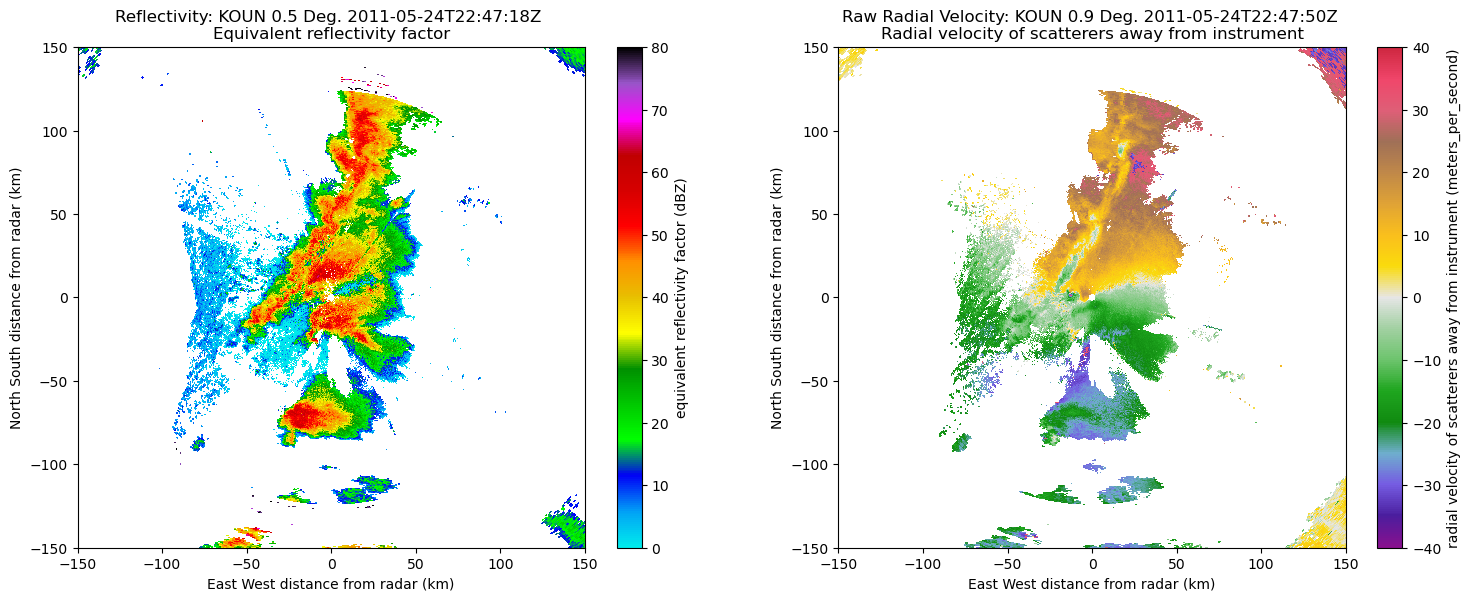

In [5]:
# Plot RAW base level data

def plot2(radar, vr_field ={'field':"velocity",     'vmax':40., 'vmin':-40., 'title':"Raw Radial Velocity"},
                 ref_field={'field':"reflectivity", 'vmax':80., 'vmin': 0.0, 'title':"Reflectivity"},
                 sweep=1, v_sweep = None):
    
    if v_sweep == None:
        v_sweep = radar.sweep_table[sweep][1]

    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize = [18,6.5])

    ax = fig.add_subplot(1,2,1)
    
    title = "%s: %s" % (ref_field['title'], display.generate_title(ref_field['field'], sweep))

    display.plot(ref_field['field'], sweep, title=title,
                        mask_outside = False,
                        cmap = cm.NWSRef,
                        vmin = ref_field['vmin'], vmax = ref_field['vmax'], ax = ax)
    display.set_limits(xlim=xplot, ylim=yplot)

# second plot

    ax = fig.add_subplot(1,2,2)
    title = "%s: %s" % (vr_field['title'], display.generate_title(vr_field['field'], v_sweep))

    display.plot(vr_field['field'], v_sweep, title=title,
                        mask_outside = False,
                        cmap = cm.Carbone17,
                        vmin = vr_field['vmin'], vmax = vr_field['vmax'], ax = ax)

    display.set_limits(xlim=xplot, ylim=yplot)
    plt.show()
    
plot2(radar)


In [4]:
#  Reset Nyquist velocity to be constant within sweeps.


for n, slice in enumerate(radar.iter_slice()):
    nyq = radar.instrument_parameters['nyquist_velocity']['data'][slice]
#     print(" Shape of nyquist:  %d" % nyq.shape)
#     print(" Initial Max/Min of nyquist:  %f   %f" % (nyq.max(), nyq.min()))
    radar.instrument_parameters['nyquist_velocity']['data'][slice] = nyq.min()
    nyq = radar.instrument_parameters['nyquist_velocity']['data'][slice]
#     print(" Final Max/Min of nyquist:    %f   %f" % (nyq.max(), nyq.min()))


In [6]:
# Unfold data and plot it again...


# dealiased_radar = pyart.correct.dealias_unwrap_phase(radar, unwrap_unit='sweep',
#                                nyquist_vel=None, check_nyquist_uniform=True,
#                                gatefilter=None, rays_wrap_around=None,
#                                keep_original=False, set_limits=True,
#                                vel_field='velocity', corr_vel_field=None,
#                                skip_checks=False)

dealiased_radar = pyart.correct.dealias_region_based(radar, interval_splits=3,
                                   interval_limits=None, skip_between_rays=100,
                                   skip_along_ray=100, centered=True,
                                   nyquist_vel=None, check_nyquist_uniform=True,
                                   gatefilter=None, rays_wrap_around=None,
                                   keep_original=False, set_limits=True,
                                   vel_field='velocity', corr_vel_field=None)

radar.add_field('unfolded velocity', dealiased_radar, replace_existing=True)

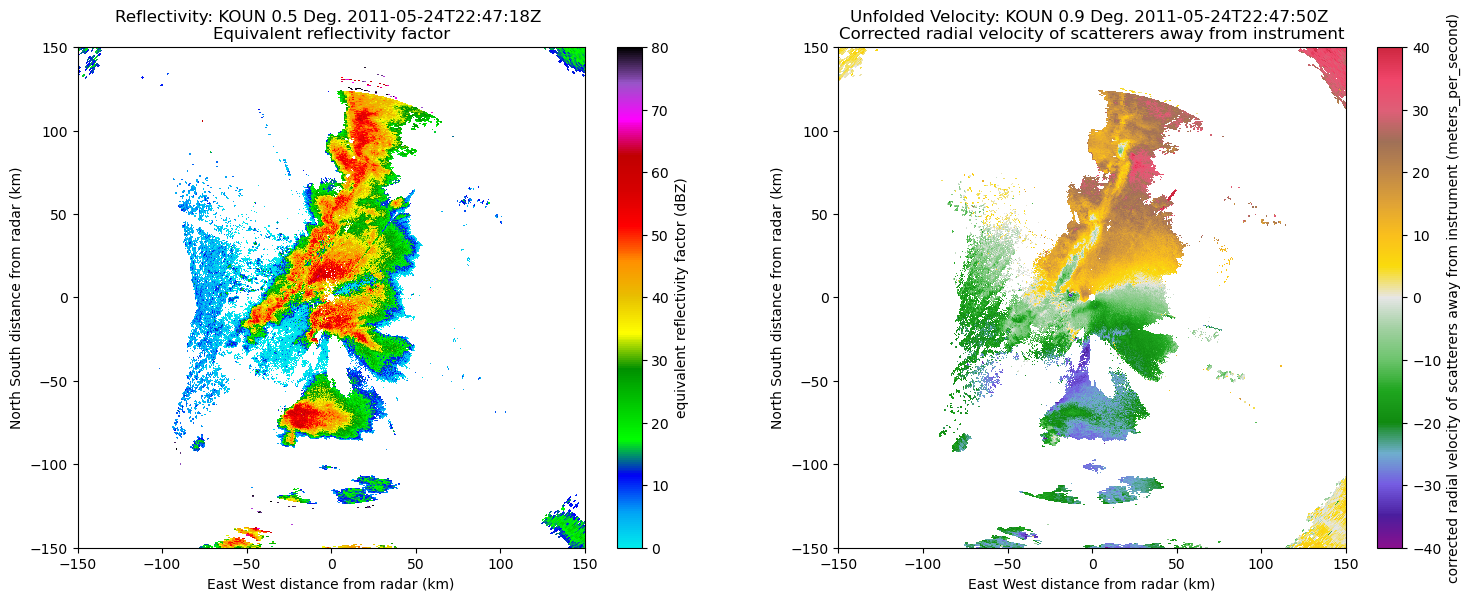

In [7]:
# Plot unfolded data

plot2(radar, vr_field ={'field':"unfolded velocity", 'vmax':40., 'vmin':-40., 'title':"Unfolded Velocity"})



In [9]:
def getAtmosAtten_dynamic(elev):
    atmos = -0.012747 + 0.001895 * elev
    atmos = np.where(atmos < -0.005, -0.005, atmos)
    atmos = np.where(atmos > -0.012, -0.012, atmos)

    return atmos

def calc_SNR(radar):
    
    _C = 31.
    
    snr = np.ma.MaskedArray(np.zeros(radar.fields['reflectivity']['data'].shape))
    
    range_km = 0.001*radar.range['data'][:] + 0.01  # Add 10 m to make sure no zero for log
    
    for n, dbz in enumerate(radar.iter_field('reflectivity')):
        
        if n == 0:
            begin = 0
            end   = radar.sweep_end_ray_index['data'][n] + 1
        else:
            begin = radar.sweep_end_ray_index['data'][n-1] + 1
            end   = radar.sweep_end_ray_index['data'][n] + 1
        
        attenuation = getAtmosAtten_dynamic(radar.elevation['data'][begin:end].mean())
        
        snr[begin:end,:] = (-20.0*np.log10(range_km)) + _C + attenuation*range_km
        
    snr = snr + radar.fields['reflectivity']['data'][:]
    
    print(snr.min(), snr.max())
    
    radar.add_field_like('reflectivity', 
                         'signal_to_noise_ratio', 
                          snr, replace_existing = True)


            
calc_SNR(radar)


-9.841766357421875 79.38642311096191


In [10]:
def unfold_PHIDP(rhv, phi, fold_in_degrees=360.):
    
    min_system_PhiDP     = 30.0
    min_rhv_thresh       = 0.85
    max_hist_median_size = 30
    half_max_hist_median_size = 25
    max_stddev = fold_in_degrees/3.0
    min_valid_data = 15
    half_fold_in_degrees = fold_in_degrees/2.0
    min_bin_unfold_start  = 300

# not completed....
    return phi
    

In [18]:
def texture(input, radius=3, oneD=False):
    
# oneD flag is used to texture PhiDP along a radial, because it should NOT be a 2D texture
# input_array_dims = [az,range], so texture over second index
  
# ndimage cannot deal with masked arrays - but can deal with nan's - so replace bad values with nan's

    i2     = input.filled(fill_value=np.nan)
    
    if len(i2.shape) == 1 or oneD == True:
        kernel = np.ones((radius))/float(radius)
        kernel2 = kernel
    else:
        kernel = np.ones((radius,radius))/float(radius*radius)
        kernel2 = kernel

    if len(i2.shape) == 2 and oneD == True:       
        std = np.empty_like(input)
        for n in np.arange(i2.shape[0]):
            avg    = scipy.ndimage.filters.convolve(i2[n], kernel2, mode='reflect', origin=0)
            dif    = i2[n] - avg
            c1     = scipy.ndimage.filters.convolve(dif,     kernel, mode='reflect', origin=0)
            c2     = scipy.ndimage.filters.convolve(dif*dif, kernel, mode='reflect', origin=0)
            std[n] = ((c2 - c1*c1)**.5)
    else:
        
        avg    = scipy.ndimage.filters.convolve(i2,      kernel2, mode='reflect', origin=0)
        dif    = i2 - avg
        c1     = scipy.ndimage.filters.convolve(dif,     kernel, mode='reflect', origin=0)
        c2     = scipy.ndimage.filters.convolve(dif*dif, kernel, mode='reflect', origin=0)
        std    = ((c2 - c1*c1)**.5)

    return np.ma.array(std, mask=np.isnan(std))


In [19]:
########################################################################
# Trap4 point

def trap4point(input, y1, y2, y3, y4):

#  abort for poor membership functions
#     if (x2-x1) < 0 or (x3-x2) < 0 or (x4-x3) < 0:
#         return 0

# Error checks for sanity.....

    assert(y2 >= y1)
    assert(y3 >= y2)
    assert(y4 >  y3)

# Create vectors for the masking

    x1 = y1*np.ones(input.shape)

    x2 = y2*np.ones(input.shape)

    x3 = y3*np.ones(input.shape)

    x4 = y4*np.ones(input.shape)
    
# create output array
    
    output      = np.ma.zeros(input.shape)
    output.mask = input.mask
    
    mask1 = np.logical_and((input >= x2), (input <= x3))   
    output[mask1] = 1.0
    
    mask2 = np.logical_or((input < x1), (input > x4))
    output[mask2] = 0.0

    mask3 = np.logical_and((input > x1), (input < x2))
    tmp = (input-x1) / (x2-x1)
    output[mask3] = tmp[mask3]

    mask4 = np.logical_and((input > x3), (input < x4))
    tmp = (x4 - input) / (x4-x3)
    output[mask4] = tmp[mask4]
            
    return output

In [43]:
########################################################################
# MetSignal:  Implementation of Krause's 2016 JTech QC algorithm in 2D

def MetSignal2D(radar, sweep = 0, v_sweep = None):

    dbz_weight     = 2.5
    rhv_weight     = 1.0
    vel_weight     = 1.0
    std_zdr_weight = 2.0
    std_phi_weight = 2.0
    std_rhv_weight = 1.0
    FLT_MAX        = 1.0e8
    met_threshold  = 70.
    
    if v_sweep == None:
        v_sweep = radar.sweep_table[sweep][1]
    
    dbz = radar.get_field(sweep, 'reflectivity')
    zdr = radar.get_field(sweep, 'differential_reflectivity')
    phi = radar.get_field(sweep, 'differential_phase')
    rhv = radar.get_field(sweep, 'cross_correlation_ratio')
    vel = radar.get_field(v_sweep, 'velocity')

# Calculate the std-deviation for texture mapping, note that phi-texturing needs to be 1D

    metsignal = -10.0*np.ones(dbz.shape)
    
    std_phi = texture(phi, radius=9, oneD=True)
    std_zdr = texture(zdr)
    std_rhv = texture(rhv)
    
# Define arrays to store weights from fuzzy logic...

    signal_value    = np.zeros(dbz.shape)
    signal_strength = np.zeros(dbz.shape) 
    weight          = np.zeros(dbz.shape) 
    sump            = np.zeros(dbz.shape, dtype=int)
    
# Process 6 fields

    signal_value = signal_value + dbz_weight*trap4point(dbz,10.0,30.0,FLT_MAX,FLT_MAX+1)
    weight       = weight + np.where(dbz.mask == False, dbz_weight, 0.0)
    sump         = sump + np.where(dbz.mask == False, 1, 0) 

    signal_value = signal_value + rhv_weight*trap4point(rhv, 0.75,0.9, FLT_MAX,FLT_MAX+1)
    weight       = weight + np.where(rhv.mask == False, rhv_weight, 0.0) 
    sump         = sump + np.where(rhv.mask == False, 1, 0) 

    signal_value = signal_value + 1.0 - vel_weight*trap4point(vel,-1.5, -1.0, 1.0, 1.5)
    weight       = weight + np.where(vel.mask == False, vel_weight, 0.0) 
    sump         = sump + np.where(vel.mask == False, 1, 0) 

    signal_value = signal_value + std_phi_weight*trap4point(std_phi,0.0, 0.0, 10., 20.)
    weight       = weight + np.where(std_phi.mask == False, std_phi_weight, 0.0) 
    sump         = sump + np.where(std_phi.mask == False, 1, 0) 

    signal_value = signal_value + std_zdr_weight*trap4point(std_zdr,0.0, 0.0, 1., 2.)
    weight       = weight + np.where(std_zdr.mask == False, std_zdr_weight, 0.0) 
    sump         = sump + np.where(std_zdr.mask == False, 1, 0) 

    signal_value = signal_value + std_rhv_weight*trap4point(std_rhv,0.0, 0.0, 0.02, 0.04)
    weight       = weight + np.where(std_rhv.mask == False, std_rhv_weight, 0.0) 
    sump         = sump + np.where(std_rhv.mask == False, 1, 0) 

# Locations with large amounts of Texture are non-meteorlogical while areas 
# with moderate to low amounts of texture are meteorlogical

    metsignal = np.where(sump >= 2, np.floor(100.*signal_value/weight), -10.)
    
# Hardlimits:  Asd some hard thresholds

# RhoHV < 0.65

    mask = np.logical_and((rhv < 0.65), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.0, metsignal)

# Zdr < -4.5
    mask = np.logical_and((zdr  < -4.5), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.1, metsignal)

# Zdr > 4.5
    mask = np.logical_and((zdr > 4.5), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.2, metsignal)

# smooth out metsignal

    kernel = np.ones((5,5))/float(25)
    metsignal    = scipy.ndimage.filters.convolve(metsignal, kernel, mode='reflect', origin=0)
    
    return metsignal

In [47]:
############################################################################
# MetSignal:  Implementation of Krause's 2016 JTech QC algorithm in 1D

def MetSignal(radar, sweep = 0, v_sweep = None):

    _verbose_QC = False

# Fuzzy logic weights for filtering from Krause (2016)

    dbz_weight     = 2.0
    rhv_weight     = 1.0
    vel_weight     = 1.0
    std_zdr_weight = 2.0
    std_phi_weight = 2.0
    std_rhv_weight = 1.0
    FLT_MAX        = 1.0e8
    met_threshold  = 50.
   
    if v_sweep == None:
        v_sweep = radar.sweep_table[sweep][1]
    
    dbz = radar.get_field(sweep, 'reflectivity')
    zdr = radar.get_field(sweep, 'differential_reflectivity')
    phi = radar.get_field(sweep, 'differential_phase')
    rhv = radar.get_field(sweep, 'cross_correlation_ratio')
    vel = radar.get_field(v_sweep, 'velocity')
   
    metsignal = -10.0*np.ones(dbz.shape)

# Compute QC along each ray

    for na in np.arange(dbz.shape[0]):
    
# Calculate the std-deviation for texture mapping

        std_phi = texture(phi[na], radius=9, oneD=True)
        std_zdr = texture(zdr[na], radius=9, oneD=True)
        std_rhv = texture(rhv[na], radius=9, oneD=True)
       
        if _verbose_QC:
            print(na, "PHI_STD: ", std_phi.max(), std_phi.min())
            print(na, "ZDR_STD: ", std_zdr.max(), std_zdr.min())
            print(na, "RHV_STD: ", std_rhv.max(), std_rhv.min())

        signal_value    = np.zeros(dbz.shape[1])
        signal_strength = np.zeros(dbz.shape[1]) 
        weight          = np.zeros(dbz.shape[1]) 
        sump            = np.zeros(dbz.shape[1], dtype=int) 
       
        signal_value = signal_value + dbz_weight*trap4point(dbz[na],10.0,30.0,FLT_MAX,FLT_MAX+1)
        weight       = weight + np.where(dbz[na].mask == False, dbz_weight, 0.0)
        sump         = sump + np.where(dbz[na].mask == False, 1, 0) 

        signal_value = signal_value + rhv_weight*trap4point(rhv[na],0.75, 0.9,FLT_MAX,FLT_MAX+1)
        weight       = weight + np.where(rhv[na].mask == False, rhv_weight, 0.0) 
        sump         = sump + np.where(rhv[na].mask == False, 1, 0) 

        signal_value = signal_value + 1.0 - vel_weight*trap4point(vel[na],-1.5, -1.0, 1.0, 1.5)
        weight       = weight + np.where(vel[na].mask == False, vel_weight, 0.0) 
        sump         = sump + np.where(vel[na].mask == False, 1, 0) 

        signal_value = signal_value + std_phi_weight*trap4point(std_phi,0.0, 0.0, 10., 20.)
        weight       = weight + np.where(std_phi.mask == False, std_phi_weight, 0.0) 
        sump         = sump + np.where(std_phi.mask == False, 1, 0) 
       
        signal_value = signal_value + std_zdr_weight*trap4point(std_zdr,0.0, 0.0, 1., 2.)
        weight       = weight + np.where(std_zdr.mask == False, std_zdr_weight, 0.0) 
        sump         = sump + np.where(std_zdr.mask == False, 1, 0) 
       
        signal_value = signal_value + std_rhv_weight*trap4point(std_rhv,0.0, 0.0, 0.02, 0.04)
        weight       = weight + np.where(std_rhv.mask == False, std_rhv_weight, 0.0) 
        sump         = sump + np.where(std_rhv.mask == False, 1, 0) 

# Locations with large amounts of Texture are non-meteorlogical while areas 
# with moderate to low amounts of texture are meteorlogical

        metsignal[na,:] = np.where(sump >= 4, np.floor(100.*signal_value/weight), -10)
    
# Hardlimits:  Asd some hard thresholds

# RhoHV < 0.65

    mask = np.logical_and((rhv < 0.65), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.0, metsignal)

# Zdr < -4.5

    mask = np.logical_and((zdr  < -4.5), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.1, metsignal)

# Zdr > 4.5

    mask = np.logical_and((zdr > 4.5), (metsignal >= met_threshold))   
    metsignal = np.where(mask, -5.2, metsignal)

# Add metsignal field to volume object

    return metsignal

In [48]:
def SimpleQC(radar):
    
    # Use some values from Krause (2016) for metsignal values

    _min_dbz               = 10.
    _spw_filter            = 25.
    _rhv_filter            = 0.90
    _zdr_filter            = 2.0
    _verbose_QC = False
    thres_vr_from_ref = True
    
    for n, m in radar.sweep_table:
        
        spw_mask  = (radar.get_field(m, 'spectrum_width').data > _spw_filter)
        ccr_mask  = (radar.get_field(n, 'cross_correlation_ratio').data < _rhv_filter )
        zdr_mask  = (radar.get_field(n, 'differential_reflectivity').data > _zdr_filter)
        ref_mask  = (radar.get_field(n, 'reflectivity').data < _min_dbz)

        if _verbose_QC: 
            print("\n Volume_prep:  ZdR   > thres:  %f  Number of gates removed:  %d" %( _zdr_filter, np.sum(zdr_mask == True)))
            print("\n Volume_prep:  RHOHV < thres:  %f  Number of gates removed:  %d" %( _rhv_filter, np.sum(ccr_mask == True)))
            print("\n Volume_prep:  SPWTH > thres:  %f  Number of gates removed:  %d" %( _spw_filter, np.sum(spw_mask == True)))   
            print("\n Volume_prep:  Number of valid DBZ gates before dual-pol masking:  %d  " % 
                         np.sum(radar.get_field(n, 'reflectivity').mask == False))
            print("\n Volume_prep:  Number of valid Velocity gates before dual-pol masking:  %d  " % 
                         np.sum(radar.get_field(m, 'velocity').mask == False))
   
        radar.get_field(n, 'reflectivity').mask = (((radar.get_field(n, 'reflectivity').mask) | ccr_mask) | zdr_mask | ref_mask)
   
        radar.get_field(n, 'reflectivity').mask = (((radar.get_field(n, 'reflectivity').mask) | ccr_mask) | zdr_mask | ref_mask)
        radar.get_field(m, 'velocity').mask     = (((radar.get_field(m, 'velocity').mask | spw_mask) | ccr_mask ) )

        if thres_vr_from_ref:
            ref_mask = radar.get_field(n, 'reflectivity').mask
            radar.get_field(m, 'velocity').mask = (((radar.get_field(m, 'velocity').mask | ref_mask) ) )

        if _verbose_QC: 
            print("\n Volume_prep:  Number of valid DBZ gates after dual-pol masking:  %d  " % 
                         np.sum(radar.get_field(n, 'reflectivity').mask == False))
            print("\n Volume_prep:  Number of valid Velocity gates after spectrum width masking:  %d \n" % 
                         np.sum(radar.get_field(m, 'velocity').mask == False))
            
    return

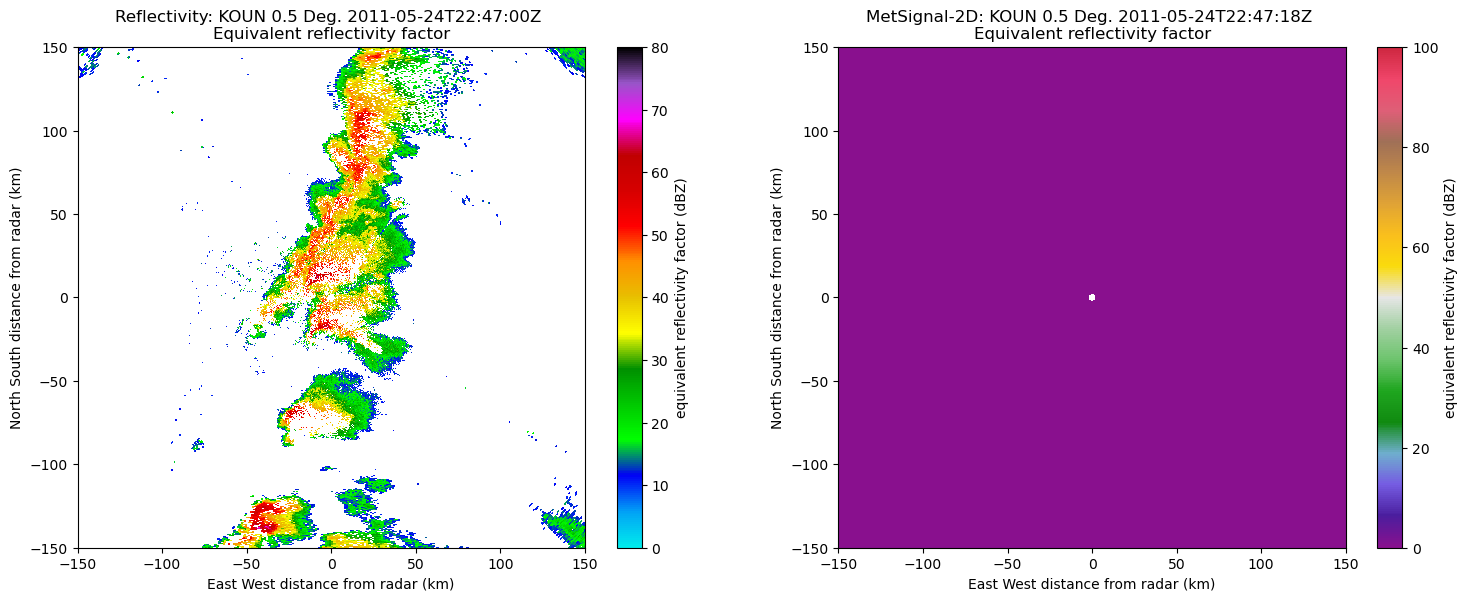

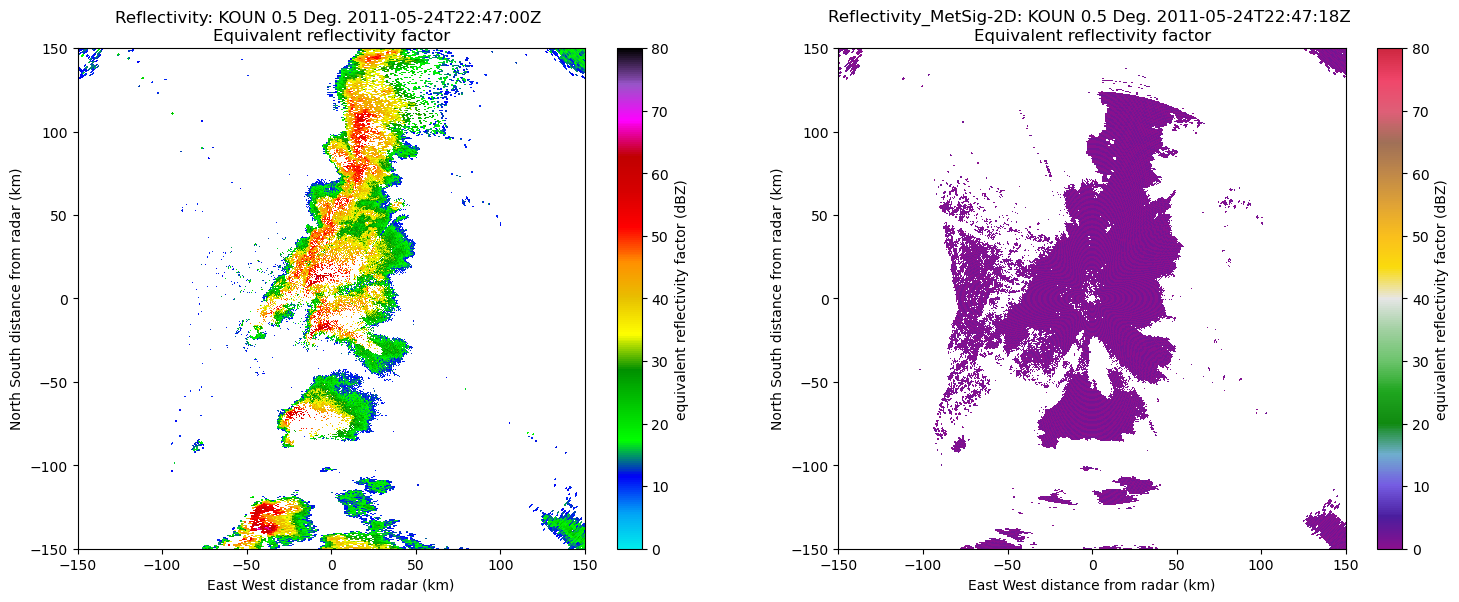

In [49]:
# Met Signal 2D processing

metsignal = np.zeros(radar.fields['reflectivity']['data'].shape)

metsignal[0:720,:] = MetSignal2D(radar)

metsignal_dbz_thres = 85.

radar.add_field_like('reflectivity', 'MetSignal', metsignal, replace_existing = True)

plot2(radar, vr_field ={'field':"MetSignal", 'vmax':100., 'vmin':0., 'title':"MetSignal-2D"}, sweep=0)

# QC the reflectivity field

dbz_QC = np.empty_like(radar.fields['reflectivity']['data'])

dbz_QC.data[0:720,:] = np.where(metsignal[0:720,:] < metsignal_dbz_thres, -9999.,radar.fields['reflectivity']['data'].data[0:720,:])
dbz_QC.mask[0:720,:] = np.where(metsignal[0:720,:] < metsignal_dbz_thres, True, False)

radar.add_field_like('reflectivity', 'reflectivity_QC', dbz_QC, replace_existing = True)

plot2(radar, vr_field ={'field':"reflectivity_QC", 'vmax':80., 'vmin':0., 'title':"Reflectivity_MetSig-2D"}, 
             ref_field={'field':"reflectivity", 'vmax':80., 'vmin': 0.0, 'title':"Reflectivity"}, sweep=0)







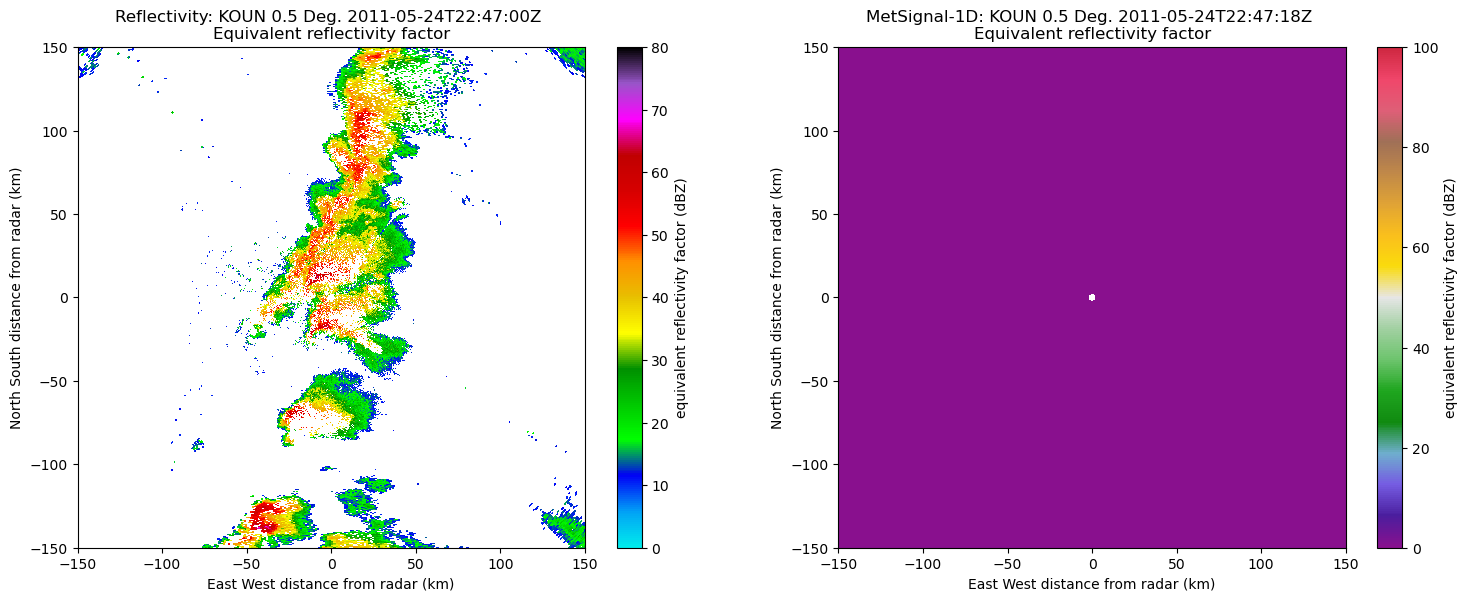

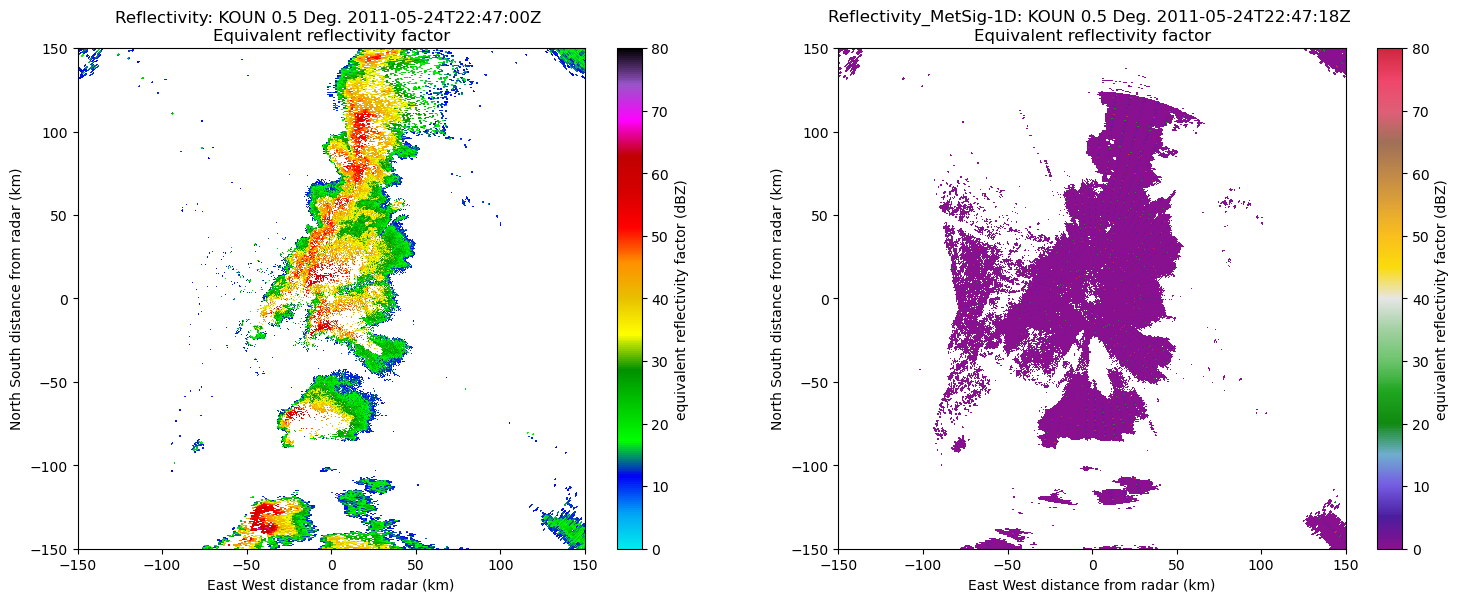

In [50]:
# Met Signal 1D processing

metsignal = np.zeros(radar.fields['reflectivity']['data'].shape)

metsignal[0:720,:] = MetSignal(radar, sweep=0)

metsignal_dbz_thres = 70.

radar.add_field_like('reflectivity', 'MetSignal', metsignal, replace_existing = True)

plot2(radar, vr_field ={'field':"MetSignal", 'vmax':100., 'vmin':0., 'title':"MetSignal-1D"}, sweep=0)

# QC the reflectivity field

dbz_QC = np.empty_like(radar.fields['reflectivity']['data'])

dbz_QC.data[0:720,:] = np.where(metsignal[0:720,:] < metsignal_dbz_thres, -9999.,radar.fields['reflectivity']['data'].data[0:720,:])
dbz_QC.mask[0:720,:] = np.where(metsignal[0:720,:] < metsignal_dbz_thres, True, False)

radar.add_field_like('reflectivity', 'reflectivity_QC', dbz_QC, replace_existing = True)

plot2(radar, vr_field ={'field':"reflectivity_QC", 'vmax':80., 'vmin':0., 'title':"Reflectivity_MetSig-1D"}, 
             ref_field={'field':"reflectivity", 'vmax':80., 'vmin': 0.0, 'title':"Reflectivity"}, sweep=0)

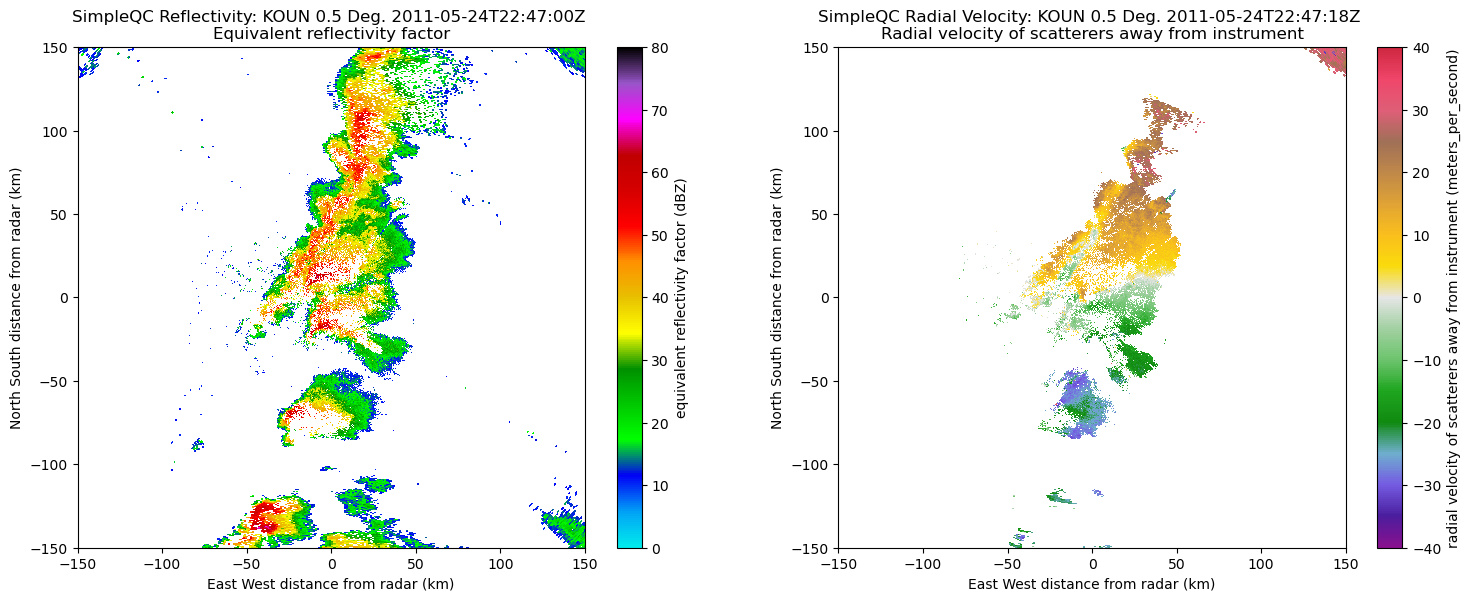

In [51]:
# Simple QC

ret = SimpleQC(radar)

#pyart.correct.despeckle.despeckle_field(radar, 'reflectivity', threshold=-10, size=10, gatefilter=None, delta=5.0)


# QC the reflectivity field

plot2(radar, vr_field ={'field':"velocity",     'vmax':40., 'vmin':-40., 'title':"SimpleQC Radial Velocity"},
             ref_field={'field':"reflectivity", 'vmax':80., 'vmin': 0.0, 'title':"SimpleQC Reflectivity"},
                 sweep=0, v_sweep = None)


    

In [17]:
for key in radar.fields:
    print key




reflectivity_QC
differential_phase
cross_correlation_ratio
spectrum_width
reflectivity
MetSignal
differential_reflectivity
velocity
unfolded velocity
signal_to_noise_ratio


In [18]:
domain = ((3000.,10000.),(-150000.,150000.),(-150000.,150000.))
shape  = (8,151,151)

dbz_3D = pyart.map.grid_from_radars(radar, shape, domain, gridding_algo="map_gates_to_grid", fields=['reflectivity'])